# Stack Overflow Tag Prediction 2: Topic Modeling

Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers. The goal of this project is to predict as many tags as possible with high precision and recall. Incorrect tags could impact user experience on StackOverflow. 

To automatically assign tags we use in a first step an unsupervised approach: the text analysis technique called topic modeling. The ultimate goal of topic modeling is to find various topics that are present in your corpus. Each document in the corpus will be made up of at least one topic, if not multiple topics.

## Import libraries and load dataset

In [2]:
import pandas as pd
import numpy as np
import nltk, re, pprint
from nltk import word_tokenize, pos_tag
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from gensim import matutils, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
from gensim.parsing.preprocessing import preprocess_documents
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords
import time
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.dummy import DummyClassifier

In [3]:
df_base = pd.read_csv('/home/marco/Documents/OC_Machine_learning/section_5/tags_stackoverflow/data-output/stackoverflow_processed_sample.csv', encoding='utf-8')
df_base.head()

,Lemma,lemmalist,tags,taglist
0,"['piece', 'c++', 'code', 'show', 'peculiar', '...",piece c++ code show peculiar behavior strange ...,"['java', 'c++', 'performance', 'optimization',...",java c++ performance optimization branch-predi...
1,"['accidentally', 'commit', 'wrong', 'file', 'g...",accidentally commit wrong file git push commit...,"['git', 'version-control', 'git-commit', 'undo...",git version-control git-commit undo pre-commit
2,"['want', 'delete', 'branch', 'locally', 'remot...",want delete branch locally remotely fail attem...,"['git', 'version-control', 'git-branch', 'git-...",git version-control git-branch git-push git-re...
3,"['difference', 'git', 'pull', 'git', 'fetch']",difference git pull git fetch,"['git', 'version-control', 'git-pull', 'git-fe...",git version-control git-pull git-fetch
4,"['mess', 'json', 'time', 'push', 'text', 'hurt...",mess json time push text hurt anybody know lik...,"['json', 'http-headers', 'content-type']",json http-headers content-type


Test and train set

In [4]:
# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(df_base['Lemma'], df_base['taglist'], test_size=0.2,train_size=0.8, random_state=0)

## 1. Document-term matrix


To use a topic modeling technique, we calculate have to calculate (1) a document-term matrix and (2) choose the number of topics for the algorithm to pick up.
Documemt-term matrix is calculated using either using the "Bag of Words" or "TF-IDF" approach.
The number of topics is chosen beforehands

In [5]:
num_features = 500

### 1.1 Bag of Words approach

In order to perform machine learning on text documents, we first need to turn the text content into numerical feature vectors, i.e build a document-term matrix.
One common approach is called a Bag of Words. The Bag of Words model learns a vocabulary from all of the documents, then models each document by counting the number of times each word appears. 

In [6]:
# Initialize the "CountVectorizer" object, which is scikit-learn's bag of words tool
c_vectorizer = CountVectorizer(analyzer = "word",tokenizer = None,  min_df=5, max_df = 0.8, max_features = num_features) 
#The input to fit_transform should be a list of strings like column "Lemma" and "tags" in our dataframe.


In [7]:
# apply the vectorizer
X_bag_of_words_train = c_vectorizer.fit_transform(X_train)
X_bag_of_words_test = c_vectorizer.transform(X_test)
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. 

In [8]:
# Numpy arrays are easy to work with, so convert the result to an array
bag_of_words_array = X_bag_of_words_train.toarray()


document-term matrix calculated with "Bag of Words" method

In [9]:
# define vocabulary words
vocab = c_vectorizer.get_feature_names()
# build a dataframe out of the bag of words
df_tf = pd.DataFrame(bag_of_words_array, columns=vocab)
print(df_tf.shape)
df_tf.head() # visualize the matrix

(29740, 500)


,able,access,achieve,action,activity,actually,add,address,alert,allow,...,word,work,world,wrap_content,write,wrong,xad,xcode,xml,yes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1.2 TF-IDF approach

Text frequency - inverse documents frequency is a more advanced approach to build a document-term matrix than bag of words where only word counts (text frequency) is used.
Inverse document frequency means, how common or rare a word is in the entire document set.
It varies between 0 and 1. The closer it is to 0, the more common a word is.
Before building the matrix here we check which are the most popular terms, i.e. the words with highest TF-IDF score. Those should correspond to the most popular tags.

#### 1.2.1 Word count and TF-IDF score


Word counts (term frequency)

In [10]:
# Sum up the counts of each vocabulary word
dist = np.sum(bag_of_words_array, axis=0)

# For each, append to a list the vocabulary word and the number of times it 
# appears in the training set
counts = []
words = []
for word, count in zip(vocab, dist):
    counts.append(count)
    words.append(word)
    
df_wordcount = pd.DataFrame({'words': words, 'count':counts})

IDF values calculated from the bag-of-words matrix

In [11]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X_bag_of_words_train)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [12]:
# get idf values
df_idf = pd.DataFrame(tfidf_transformer.idf_, index= c_vectorizer.get_feature_names(),columns=["idf_weight"]).reset_index()
df_idf.rename(columns={'index':'words'},inplace=True) 

# join with word counts data
df_words = pd.merge(df_idf, df_wordcount, on='words', how='inner')

Finally we get a words dataframe ordered by TF-IDF scores

In [13]:
#calculate the TF-IDF score
df_words['TF_IDF score'] = df_words["idf_weight"]*df_words['count']
df_words = df_words.sort_values(by=['TF_IDF score'], ascending=False).reset_index(drop = True)# sort ascending
df_words[:10]

,words,idf_weight,count,TF_IDF score
0,file,2.762306,12047,33277.501751
1,android,4.163799,7167,29841.944821
2,string,3.089614,8716,26929.073994
3,class,3.167575,8414,26651.979033
4,like,2.265724,11627,26343.578205
5,use,2.448332,10230,25046.438129
6,error,3.041341,8205,24954.206033
7,function,3.123890,7572,23654.096955
8,code,2.631742,8939,23525.140847
9,new,2.890006,7985,23076.697392


#### 1.2.2 Build the matrix: TF-IDF scores to vectors

In [14]:
tfidfVectorizer = TfidfVectorizer(norm=None,analyzer='word',min_df = 5, max_df = 0.8, max_features = num_features, use_idf=True)

In [15]:
# TF-IDF matrices
X_tfidf_train = tfidfVectorizer.fit_transform(X_train)
X_tfidf_test = tfidfVectorizer.transform(X_test)

In [16]:
dense = X_tfidf_train.todense()

In [17]:
denselist = dense.tolist()

In [18]:
df_tf_idf = pd.DataFrame(denselist, columns = tfidfVectorizer.get_feature_names())
df_tf_idf.rename(columns={'index':'words'},inplace=True)
print(df_tf_idf.shape)
df_tf_idf.head()

(29740, 500)


,able,access,achieve,action,activity,actually,add,address,alert,allow,...,word,work,world,wrap_content,write,wrong,xad,xcode,xml,yes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Unsupervised topic modeling

In [19]:
# Define a time counter function to test the algorythm performance 
_start_time = time.time()

def process_time_starts():
    global _start_time 
    _start_time = time.time()

def time_elapsed():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('The process took: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

### 2.1 Latent Dirichlet Allocation (LDA) topic model

#### 2.1.1 Choice of training data and hyperparameters: perplexity and coherence metrics

Perplexity is essentially a measure of how puzzled a trained model is by previously unseen documents. The core measure here is log-likelihood, which looks at the probability of seeing the content of the unseen documents given the trained model — i.e. does the model generalize? If it doesn’t, the log-likelihood is very low and perplexity ((exp(-1. * log-likelihood per word)) is high. A good model will have low perplexity.

In [20]:
# given a vectorizer and set of data we calculate the perplexity as a function of topics evaluated

def lda(vectorizer, data_train, data_test):

    ''' Showing the perplexity score for several LDA models with different values
    for n_components parameter, and printing the top words for the best LDA model
    (the one with the lowest perplexity)
    Parameters:
    vectorizer: TF-IDF or Bag-of-Words convertizer                                              
    data_train: data to fit the model with
    data_test: data to test
    '''

    best_perplexity = np.inf
    best_lda = 0
    perplexity_list = []
    n_topics_list = []
    print("Extracting term frequency features for LDA...")

    for n_topics in np.linspace(10, 200, 5, dtype='int'):
        lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                        learning_method='online',
                                        learning_offset=50.,
                                        random_state=0).fit(data_train)
        n_topics_list.append(n_topics)
        perplexity = lda_model.perplexity(data_test)
        perplexity_list.append(perplexity)

        # Perplexity is defined as exp(-1. * log-likelihood per word)
        # Perplexity: The smaller the better
        if perplexity <= best_perplexity:
            best_perplexity = perplexity
            best_lda = lda_model
                                
    plt.title("Evolution of perplexity score depending on number of topics")
    plt.xlabel("Number of topics")
    plt.ylabel("Perplexity")
    plt.plot(n_topics_list, perplexity_list)
    plt.show()

Extracting term frequency features for LDA...


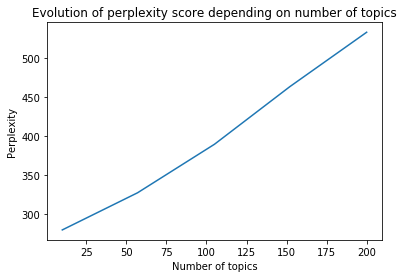

The process took: 0hour:5min:47sec


In [21]:
process_time_starts()
lda(c_vectorizer, X_bag_of_words_train, X_bag_of_words_test)
time_elapsed()

Extracting term frequency features for LDA...


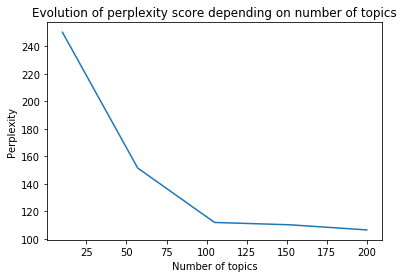

The process took: 0hour:5min:36sec


In [22]:
process_time_starts()
lda(tfidfVectorizer,X_tfidf_train, X_tfidf_test )
time_elapsed()

#### 2.1.2 Recommendation algorithm based on LDA optimized model

In [23]:
n_topics = 150 # based on perplexity calculations
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                        learning_method='online',
                                        learning_offset=50.,
                                        random_state=0).fit(X_tfidf_train)

def Recommend_tags_lda(text):
    
    ''' Recomendation system for stackoverflow posts based on a lda model, 
    it returns up to 5 tags.
    Parameters:
    text: the stackoverflow post of user
    data_train: data to fit the model with
    '''

    threshold = 0.012
    list_scores = []
    list_words = []
    used = set()
       
    text_tfidf = tfidfVectorizer.transform([text])
    text_projection = lda_model.transform(text_tfidf)
    feature_names = tfidfVectorizer.get_feature_names()
    lda_components = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis] # normalization

    for topic in range(n_topics):
        topic_score = text_projection[0][topic]

        for (word_idx, word_score) in zip(lda_components[topic].argsort()[:-5:-1], sorted(lda_components[topic])[:-5:-1]):
            score = topic_score*word_score

            if score >= threshold:
                list_scores.append(score)
                list_words.append(feature_names[word_idx])
                used.add(feature_names[word_idx])

    results = [tag for (y,tag) in sorted(zip(list_scores,list_words), key=lambda pair: pair[0], reverse=True)]
    unique_results = [x for x in results if x not in used] # get only unique tags
    tags = " ".join(results[:5])
    
    return tags

In [24]:
process_time_starts()
LDA_tags = [Recommend_tags_lda(text) for text in X_test ]
time_elapsed()

The process took: 0hour:4min:10sec


In [25]:
df_xtest = pd.DataFrame(X_test).reset_index()
df_ytest = pd.DataFrame(y_test).reset_index()

df_test = pd.merge(df_xtest, df_ytest)
df_test.drop('index', axis=1, inplace=True)
df_test['LDA_tags'] = LDA_tags
df_test.head()

,Lemma,taglist,LDA_tags
0,"['try', 'install', 'libv', 'get', 'error', 'os...",gem rubygems osx-mavericks osx-yosemite libv8,self target valid error build
1,"['question', 'twitter', 'bootstrap', 'cs', 'su...",css html twitter-bootstrap twitter-bootstrap-3,android div project question html
2,"['work', 'code', 'write', 'previous', 'develop...",mysql sql operators spaceship-operator,select null error solution python
3,"['compiler', 'gcc', 'give', 'warn', 'warn', 'i...",c compiler-warnings,give function let container site
4,"['possible', 'exchange', 'job', 'different', '...",jenkins,way find know different exception


#### 2.1.3 Performance evaluation of LDA predictions

##### Baseline: we create a tags vector with a dummy classifier 

In [26]:
# Dummy Classifier (baseline)

dummy_clf = DummyClassifier(random_state=0, strategy="most_frequent")
model_dummy = dummy_clf.fit(X_tfidf_train, y_train)
y_dummy_pred = model_dummy.predict(X_tfidf_test)

##### Cosine similarity as score metrics:

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them.
We have to construct a vector space from all the ‘sentences’ in tags arrays. We do so by using the TF-IDF approach.

In [27]:
y_tfidf_test = tfidfVectorizer.transform(y_test)
y_tfidf_LDA = tfidfVectorizer.transform(LDA_tags)
y_tfidf_dummy = tfidfVectorizer.transform(y_dummy_pred)
#print(y_tfidf_test.shape, y_tfidf_LDA.shape, y_tfidf_dummy.shape)

##### Verify scores

In [28]:
# Cosine similarity varies between 0 and 1.
# If the predicted tags are exactly the same as those given by stackoverflow, cosine similarity is = 1
#  to have one number we need reshaping 1D vectors representing tags, as 2D vectors(-1,1)
print('Dummy score:',cosine_similarity(y_tfidf_test.reshape(1,-1), y_tfidf_dummy.reshape(1,-1))) 
print('LDA score:',cosine_similarity(y_tfidf_test.reshape(1,-1), y_tfidf_LDA.reshape(1,-1)))

Dummy score: [[0.04150446]]
LDA score: [[0.12926921]]


In [30]:
n_topics = 150 # based on perplexity calculations
nmf_model = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(X_tfidf_train)

def Recommend_tags_nmf(text, model):
    
    ''' Recomendation system for stackoverflow posts based on a lda model, 
    it returns up to 5 tags.
    Parameters:
    text: the stackoverflow post of user
    data_train: data to fit the model with
    '''

    threshold = 0.012
    list_scores = []
    list_words = []
    used = set()
       
    text_tfidf = tfidfVectorizer.transform([text])
    text_projection = model.transform(text_tfidf)
    feature_names = tfidfVectorizer.get_feature_names()
    components = model.components_ / model.components_.sum(axis=1)[:, np.newaxis] # normalization

    for topic in range(n_topics):
        topic_score = text_projection[0][topic]

        for (word_idx, word_score) in zip(components[topic].argsort()[:-5:-1], sorted(components[topic])[:-5:-1]):
            score = topic_score*word_score

            if score >= threshold:
                list_scores.append(score)
                list_words.append(feature_names[word_idx])
                used.add(feature_names[word_idx])

    results = [tag for (y,tag) in sorted(zip(list_scores,list_words), key=lambda pair: pair[0], reverse=True)]
    unique_results = [x for x in results if x not in used] # get only unique tags
    tags = " ".join(results[:5])
    
    return tags

In [32]:
process_time_starts()
NMF_tags = [Recommend_tags_nmf(text, nmf_model) for text in X_test ]
time_elapsed()

The process took: 0hour:3min:45sec


In [33]:
df_test['NMF_tags'] = NMF_tags
df_test.head()

,Lemma,taglist,LDA_tags,NMF_tags
0,"['try', 'install', 'libv', 'get', 'error', 'os...",gem rubygems osx-mavericks osx-yosemite libv8,self target valid error build,target pointer main install static
1,"['question', 'twitter', 'bootstrap', 'cs', 'su...",css html twitter-bootstrap twitter-bootstrap-3,android div project question html,project
2,"['work', 'code', 'write', 'previous', 'develop...",mysql sql operators spaceship-operator,select null error solution python,null mysql join root developer
3,"['compiler', 'gcc', 'give', 'warn', 'warn', 'i...",c compiler-warnings,give function let container site,warn format argument character function
4,"['possible', 'exchange', 'job', 'different', '...",jenkins,way find know different exception,


In [35]:
y_tfidf_NMF = tfidfVectorizer.transform(NMF_tags)
print('Dummy score:',cosine_similarity(y_tfidf_test.reshape(1,-1), y_tfidf_dummy.reshape(1,-1))) 
print('NMF score:',cosine_similarity(y_tfidf_test.reshape(1,-1), y_tfidf_NMF.reshape(1,-1)))

Dummy score: [[0.04150446]]
NMF score: [[0.16651753]]
